In [2]:
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta
from collections import deque
import numpy as np
import math
import time
import altair as alt
#from neuralprophet import NeuralProphet

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from orbit.utils.simulation import make_trend, make_seasonality, make_regression

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 8]

%matplotlib inline

import pandas as pd
import random
random.seed()

myfreq = "D" # "D" or "1MIN"
if myfreq == "1MIN":
    xs = pd.date_range("00:00", "23:59", freq=myfreq)
else:
    xs = pd.date_range(start='1/1/2018', end='1/1/2022', freq=myfreq)
xs

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01'],
              dtype='datetime64[ns]', length=1462, freq='D')

In [3]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1

    #anomaly importances
    '''
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    '''
    
    return forecasted
def plot_anomalies(forecasted, mytitle='Anomaly Detection'):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T', axis=alt.Axis(format='%H:%M'), title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title=mytitle
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

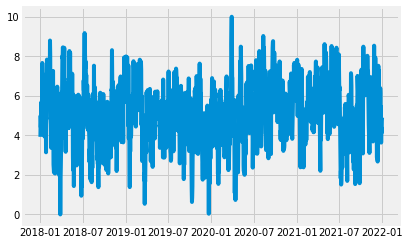

In [4]:
## generate random data

multiplier = 10

## random walk
# rw = make_trend(len(xs), rw_loc=0.01, rw_scale=1, seed=random.randint(1, 2000))
# # normalize [0, 1.5]
# y= 1 + (multiplier*(rw - np.min(rw))/np.ptp(rw))
# _ = plt.plot(xs, y)

## fourier
# fs = make_seasonality(len(xs), seasonality=random.randint(100, 1000), method='fourier', order=random.randint(4, 10), seed=random.randint(1, 2000))
# y = 1 + (multiplier*(fs - np.min(fs))/np.ptp(fs))
# _ = plt.plot(y)

# arma
arma_trend =  make_trend(len(xs), method='arma', arma=[.8, -.1], seed=random.randint(1, 2000))
# normalize [0, 1.5]
y = (multiplier*(arma_trend - np.min(arma_trend))/np.ptp(arma_trend))
_ = plt.plot(xs, y)

# # discrete
# ds = make_seasonality(len(xs), seasonality=random.randint(20, 50), duration=random.randint(2, 50), method='discrete', seed=random.randint(1, 2000))
# y = (multiplier*(ds - np.min(ds))/np.ptp(ds))
# _ = plt.plot(xs, y)

df = pd.DataFrame({"ds" : xs, "y" : y})

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline
mydf = pd.Series(y, xs)

## shared parameters among different models

max_interval = 1440 # max training time interval
one_step_len = 5 ## re-fit model every five steps
n_loops = (len(mydf) // one_step_len) - 1
confidence_interval_level = 3 ## 1 for 68%, 2 for 95% and 3 standard deviation for 99.7%. use 3 or 2

In [6]:
## SARIMAX model fit

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels as sm
# mydf2, mytest = mydf[:1000], mydf[1000:1010]
# model = SARIMAX(mydf2, order=(1,1,1))
# model_fit = model.fit(disp=0)
# res = model_fit.get_forecast(10, alpha=0.05)
# res.conf_int()
# res1 = model_fit.forecast(10, alpha=0.05)
# res1
# fc_series = pd.Series(fc, index=mytest.index)
# lower_series = pd.Series(conf[:, 0], index=mytest.index)
# upper_series = pd.Series(conf[:, 1], index=mytest.index)

print(n_loops)
fcall = None
lowerall = None
upperall = None

for i1 in range(10, n_loops): # 39 for normal period and 59 for all
    i = i1 * one_step_len
    mydf1, mytest = mydf[0:i+one_step_len].copy(), mydf[i+one_step_len: i + one_step_len*2].copy() # no max interval
    order = (1,1,1)
    seasonal_order= (0,0,0,0)
    enforce_stationarity = True
    myfit = SARIMAX(mydf1,enforce_stationarity=enforce_stationarity, order=order, seasonal_order=seasonal_order).fit(disp=False)

    alpha = 0.003 if confidence_interval_level == 3 else 0.05 if confidence_interval_level == 2 else 0.32
    fc_series = myfit.forecast(one_step_len)
    intervals = myfit.get_forecast(one_step_len).conf_int(alpha=alpha)
    lower_series, upper_series = intervals["lower y"], intervals["upper y"]
    
    if fcall is None:
        fcall = fc_series.copy()
        lowerall = lower_series.copy()
        upperall = upper_series.copy()
    else:
        fcall = pd.concat([fcall, fc_series.copy()])
        lowerall = pd.concat([lowerall, lower_series.copy()])
        upperall = pd.concat([upperall, upper_series.copy()])
        
        

291


In [7]:
## plot SARIMAX

tf1 = pd.DataFrame({"ds" : mydf.index, "yhat" : fcall, "yhat_lower" : lowerall, "yhat_upper" : upperall, "fact" : mydf})
detected_anomalies = detect_anomalies(tf1)
plot_anomalies(detected_anomalies, mytitle="SARIMAX Anomaly Detection")

alt.LayerChart(...)

In [27]:
## Holt-Winters Exponential Smoothing model fit

print(n_loops)
total_forecast = None
mses = []
fcast_total2 = None
fcast_upper = None
fcast_lower = None

for i1 in range(10, n_loops): # 39 for normal period and 59 for all
    i = i1 * one_step_len
    mydf1, df_val1 = mydf[0:i+one_step_len].copy(), mydf[i+one_step_len: i + one_step_len*2].copy().reset_index() # no max interval
    fit2 = Holt(mydf1, initialization_method="estimated").fit()
    fcast2 = fit2.forecast(one_step_len).rename("Holt's")
      
#     fit2 = ExponentialSmoothing(
#     mydf1,
#     seasonal_periods=365,
#     trend="add",
#     seasonal="add",
#     damped_trend=True,
#     use_boxcox=True,
#     initialization_method="estimated",
#     ).fit()
#     fcast2 = fit2.forecast(one_step_len).rename("Holt-Winters (add-mul-seasonal)")

    
#     fit2 = Holt(mydf1, exponential=True, initialization_method="estimated").fit()
#     fcast2 = fit2.forecast(one_step_len).rename("Exponential")

#     fit2 = Holt(mydf1, damped_trend=True, initialization_method="estimated").fit(
#         damping_trend=0.98
#     )
#     fcast2 = fit2.forecast(one_step_len).rename("Additive Damped")
    
#     fit2 = Holt(
#         mydf1, exponential=True, damped_trend=True, initialization_method="estimated"
#     ).fit()
#     fcast2 = fit2.forecast(one_step_len).rename("Multiplicative Damped")
    
    std2 = confidence_interval_level * np.sqrt(fit2.sse / len(mydf1))
    fcast2lower = fcast2 - std2
    fcast2upper = fcast2 + std2
    fcast2lower, fcast2upper
    if fcast_total2 is None:
        fcast_total2 = fcast2.copy()
        fcast_lower = fcast2lower.copy()
        fcast_upper = fcast2upper.copy()
    else:
        fcast_total2 = pd.concat([fcast_total2, fcast2.copy()])
        fcast_lower = pd.concat([fcast_lower, fcast2lower.copy()])
        fcast_upper = pd.concat([fcast_upper, fcast2upper.copy()])
        
    
# plt.figure(figsize=(12, 8))
# plt.plot(mydf, marker="o", color="black")
# plt.plot(fcast_total2, color="blue")
# plt.plot(fcast_upper, color="red")
# plt.plot(fcast_lower, color="green")
# plt.show()

291


/Users/tybalex/.pyenv/versions/3.8.6/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [28]:
## plot results
total_forecast = pd.DataFrame({"ds" : mydf.index, "yhat" : fcast_total2, "yhat_lower" : fcast_lower, "yhat_upper" : fcast_upper, "fact" : mydf})
detected_anomalies = detect_anomalies(total_forecast)
plot_anomalies(detected_anomalies, mytitle="Holt-Winters Anomaly Detection")

alt.LayerChart(...)

In [32]:
## Facebook Prophet model fit
print(n_loops)
total_forecast = None
mses = []
max_val = multiplier 
max_interval=600 ##for fb prophet, the max interval needs to be a smaller number
growth = "linear" # logistic or linear or flat?  ## linear seems to be more stable

for i1 in range(20, n_loops): # 39 for normal period and 59 for all
    i = i1 * one_step_len
    df_train1, df_val1 = df[0:i+one_step_len].copy(), df[i+one_step_len: i + one_step_len*2].copy().reset_index() # no max interval
    lb = 0 if i1 == n_loops-1 else max(0, i + one_step_len - max_interval)
    df_train1, df_val1 = df[lb:i+one_step_len].copy(), df[i+one_step_len: i + one_step_len*2].copy().reset_index()
    fact_values = list(df_val1['y'].values)
    
    if growth == "logistic":
        df_train1['cap'], df_val1['cap'] = max_val, max_val
        df_train1['floor'], df_val1['floor'] = 0.0, 0.0
    pm = Prophet(growth=growth,
    yearly_seasonality=False, 
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    interval_width=(0.997 if confidence_interval_level==3 else 0.95 if confidence_interval_level==2 else 0.68),        
    ) # need to add min_seasonality
    #pm = pm.add_seasonality(name='half_daily', period=500, fourier_order=10) ## tuneable value: period (unit: day), fourier_order: 
    #pm = pm.add_seasonality(name='hourly', period=0.1, fourier_order=10)
    pm.fit(df_train1)   
    future = pm.make_future_dataframe(periods=one_step_len,freq=myfreq,include_history=False,)
    future["cap"] = max_val
    future["floor"] = 0.0
    future_forecast = pm.predict(future)
    #future_forecast = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']]
        
        
    future_forecast['fact'] = fact_values
    
#     mse = sum([(f-p) * (f-p) for f,p in zip(fact_values, predicted_values)]) / len(fact_values)
#     mses.append(mse)
#     future_forecast['yhat_upper'] = updated_upper_stds
#     future_forecast['yhat_lower'] = updated_lower_stds
    #future_forecast['y'] = df_val1['y']
    #pm.plot(future_forecast)
    if total_forecast is None:
        total_forecast = future_forecast.copy()
    else:
        total_forecast = pd.concat([total_forecast,future_forecast.copy()])
total_forecast = total_forecast.reset_index()

291
Initial log joint probability = -6.23736
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       142.556   1.06166e-07       29.4649      0.1276           1      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       142.556   5.56839e-06       25.0981   1.619e-07       0.001      197  LS failed, Hessian reset 
     118       142.557   1.16467e-06       28.4344   4.388e-08       0.001      250  LS failed, Hessian reset 
     125       142.557   1.94155e-08       28.6979       0.413           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.44217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       150.256   4.63771e-05       27.5983           1           1      142   
    Iter      log prob        ||dx||      ||grad|

In [33]:
## plot results
detected_anomalies = detect_anomalies(total_forecast)
plot_anomalies(detected_anomalies, mytitle="fbprophet Anomaly Detection")

alt.LayerChart(...)